# Brownian Motion

Create simulation

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import torch
from pygsig.graph import StaticGraphTemporalSignal
import torch_geometric.transforms as T
from pygsig.signature import SignatureFeatures, StatFeatures

class Simulation():
    def __init__( self,num_nodes,num_blocks, p_across_blocks,p_within_blocks, mu_gain,beta_gain,sigma_gain,omega_noise,time_horizon,dt = 1e-3):
        self.num_nodes = num_nodes
        self.num_blocks = num_blocks
        self.p_across_blocks = p_across_blocks
        self.p_within_blocks = p_within_blocks
        self.mu_gain = mu_gain
        self.beta_gain = beta_gain
        self.sigma_gain = sigma_gain
        self.omega_noise = omega_noise
        self.time_horizon = time_horizon
        self.dt = dt
        self.num_time_steps = int(time_horizon / dt)

    def run(self,graph_seed,omega_seed,param_seed):

        # synchronization
        def kuramoto(graph, theta, omega, dt):
            dtheta = omega * dt  # Initialize with intrinsic frequencies
            for u, v, data in graph.edges(data=True):
                coupling = data['weight']
                dtheta[u] += dt * coupling * np.sin(theta[v] - theta[u])
                dtheta[v] += dt * coupling * np.sin(theta[u] - theta[v])
            return theta + dtheta

        # drift of the SDE
        def periodic_drift(beta, theta, omega, mu_0, t):
            return mu_0 + beta*np.sin(omega*t + theta)

        # Create a graph
        block_sizes = [self.num_nodes // self.num_blocks] * self.num_blocks
        block_probs = np.zeros((self.num_blocks, self.num_blocks))

        for i in range(self.num_blocks):
            for j in range(self.num_blocks):
                if i == j:
                    block_probs[i, j] = self.p_within_blocks
                else:
                    block_probs[i, j] = self.p_across_blocks
        
        graph = nx.stochastic_block_model(block_sizes, block_probs, seed=graph_seed)

        for edge in graph.edges:
            if graph.nodes[edge[0]]['block'] == graph.nodes[edge[1]]['block']:
                graph[edge[0]][edge[1]]['weight'] = 1/(np.sqrt(graph.degree[edge[0]]*graph.degree[edge[1]]))
            else:
                graph[edge[0]][edge[1]]['weight'] = 1/(np.sqrt(graph.degree[edge[0]]*graph.degree[edge[1]]))
        
        # Assign omega to each node
        np.random.seed(omega_seed)
        omega_range = np.linspace(0,1, self.num_blocks+1)[1:]
        for node in graph.nodes:
            graph.nodes[node]['omega'] = omega_range[graph.nodes[node]['block']] + self.omega_noise * np.random.randn()
        
        # Othe oscilator perameters
        np.random.seed(param_seed)
        omega = np.array([graph.nodes[node]['omega'] for node in graph.nodes])
        beta =  self.beta_gain * np.random.rand(self.num_nodes) # amplitude (uniform nodes)
        theta = 2 * np.pi * np.random.rand(self.num_nodes)  # initial phase (random across nodes)
        mu_0 = self.mu_gain * np.random.rand(self.num_nodes)

        # initial values
        X = np.random.rand(self.num_nodes) # signal

        # Simulate
        theta_traj = np.zeros((self.num_nodes,self.num_time_steps))
        mu_traj = np.zeros((self.num_nodes,self.num_time_steps))
        X_traj = np.zeros((self.num_nodes,self.num_time_steps))

        # Time sequence
        tt = np.arange(0, self.time_horizon, self.dt)
        for step,t in enumerate(tt):
            theta_traj[:, step] = theta
            if step == 0:
                mu_traj[:,step] = mu_0
            else:
                mu_traj[:,step] = mu
            X_traj[:,step] = X
            theta = kuramoto(graph, theta, omega,self.dt)
            mu = periodic_drift(beta, theta,omega, mu_0, t)
            X = X + self.dt * mu + np.sqrt(self.dt) * self.sigma_gain*np.random.randn(self.num_nodes)

        return X_traj, theta_traj, mu_traj, omega, mu_0, beta,  graph


In [3]:
def get_sequence(X_traj,graph):
    snapshot_count = X_traj.shape[1]
    df_edge = nx.to_pandas_edgelist(graph.to_directed())
    edge_index = torch.tensor(df_edge[['source','target']].values.T,dtype=torch.long)
    edge_weight = torch.tensor(df_edge['weight'].values,dtype=torch.float)
    snapshot_count = X_traj.shape[1]
    features = [ torch.tensor(X_traj[:,t],dtype=torch.float).unsqueeze(-1) for t in range(snapshot_count)]
    targets = [ torch.tensor(np.array([graph.nodes[node]['omega'] for node in graph.nodes]),dtype=torch.float).unsqueeze(-1) for _ in range(snapshot_count)]
    # Sequential Data
    return StaticGraphTemporalSignal(edge_index=edge_index,edge_weight=edge_weight,features=features,targets=targets)

Test simulation

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors

simulation =   Simulation(num_nodes= 20,
                num_blocks=2,
                p_across_blocks=0.1,
                p_within_blocks=0.5,
                mu_gain= 1.0,
                beta_gain=5.0,
                sigma_gain=1.0,
                omega_noise=0.1,
                time_horizon=10,
                dt=1e-3)

X_traj, theta_traj, mu_traj, omega, mu_0, beta, graph = simulation.run(graph_seed=32,omega_seed=29,param_seed=29)

In [ ]:
import networkx as nx

import matplotlib.pyplot as plt

# Get the block information for each node
blocks = nx.get_node_attributes(graph, 'block')

# Create a color map for the blocks
unique_blocks = list(set(blocks.values()))
colors = ['#012169','#4B9CD3']
block_color_map = {block: colors[i] for i, block in enumerate(unique_blocks)}

# Assign colors to nodes based on their block
node_colors = [block_color_map[blocks[node]] for node in graph.nodes]

# Draw the graph
plt.figure(figsize=(4, 4),dpi=200)
nx.draw(graph, node_color=node_colors,pos=nx.circular_layout(graph), node_size=100, font_size=10, font_color='white')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors

norm = mcolors.Normalize(vmin=0, vmax=1)

fig, ax = plt.subplots(figsize=(10, 4),dpi=200)
cmap = cm.get_cmap('Spectral')


for node in range(simulation.num_nodes):
    sns.lineplot(x=np.linspace(0, simulation.time_horizon, simulation.num_time_steps), 
                 y=X_traj[node, :], 
                 color=block_color_map[blocks[node]], 
                 ax=ax)

# Create ScalarMappable for colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

plt.xlabel('$t$')
plt.ylabel('$X$')
plt.show()

Make dataset consisting of multiple SDE trajectories

In [ ]:
from tqdm import tqdm

simulation =   Simulation(num_nodes= 300,
            num_blocks=3,
            p_across_blocks=0.01,
            p_within_blocks=0.1,
            mu_gain= 1,
            beta_gain=4,
            sigma_gain=1.0,
            omega_noise=0.0,
            time_horizon=10,
            dt=1e-3)



seq_dataset = []
num_runs = 20

with tqdm(total=num_runs) as pbar:
    for run in range(num_runs):
        paths, theta, mu, omega, mu_0, beta, graph = simulation.run(graph_seed=run,omega_seed=run,param_seed=run)
        seq = get_sequence(paths,graph)
        seq_dataset.append(seq)
        pbar.update(1)

save/load dataset

In [10]:
import torch
filename = 'datasets/brownian/1d-3b.pt'
# torch.save(seq_dataset,filename)
seq_dataset = torch.load(filename)

In [19]:
print(f"Number of Graphs: {len(seq_dataset)}")
print(f"Number of Nodes: {seq_dataset[0].num_nodes}")
print(f"Number of Edges: {seq_dataset[0][0].num_edges}")
print(f"Number of Features: {seq_dataset[0].num_node_features}")

Number of Graphs: 20
Number of Nodes: 300
Number of Edges: 3702
Number of Features: 1


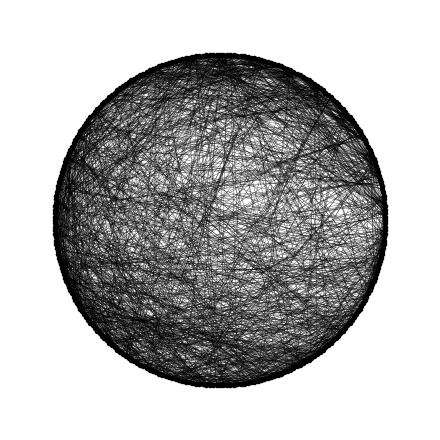

In [44]:
import networkx as nx
import matplotlib.pyplot as plt

graph = nx.from_edgelist(seq_dataset[0].edge_index.T.numpy())

# Draw the graph
plt.figure(figsize=(2, 2),dpi=200)
nx.draw(graph,pos=nx.circular_layout(graph), node_size=1, width=0.1, font_size=5, node_color='black')
plt.show()

Train, baby, train!

Signature depth: 1


100%|██████████| 20/20 [00:21<00:00,  1.06s/it]


Name: GCNRegression
Number of parameters: 3
Number of layers: 1
Signature depth: 1
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [00:41<00:00,  9.73it/s]


MSE: 0.0881 ± 0.0155, MAE: 0.2546 ± 0.0294, RMSE: 0.2958 ± 0.0254


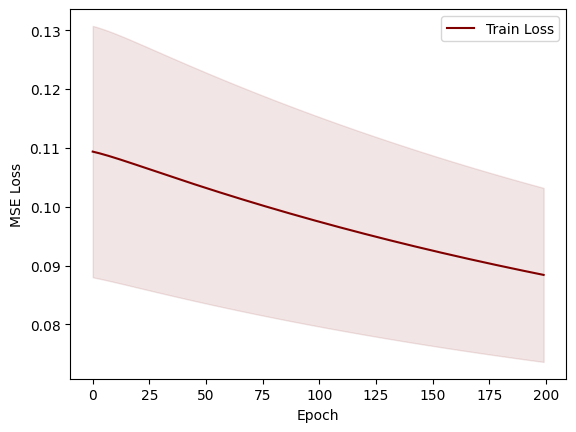

Name: GCNRegression
Number of parameters: 257
Number of layers: 2
Signature depth: 1
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [02:20<00:00,  2.85it/s]

MSE: 0.0467 ± 0.0166, MAE: 0.1818 ± 0.0358, RMSE: 0.2125 ± 0.0387


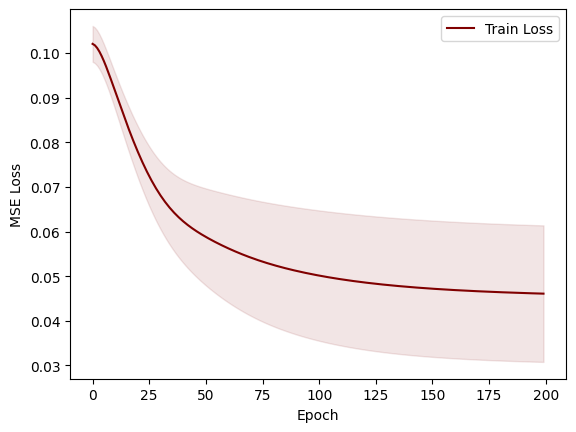

Name: GCNRegression
Number of parameters: 4417
Number of layers: 3
Signature depth: 1
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [03:58<00:00,  1.68it/s]

MSE: 0.0327 ± 0.0182, MAE: 0.1502 ± 0.0448, RMSE: 0.1744 ± 0.0477


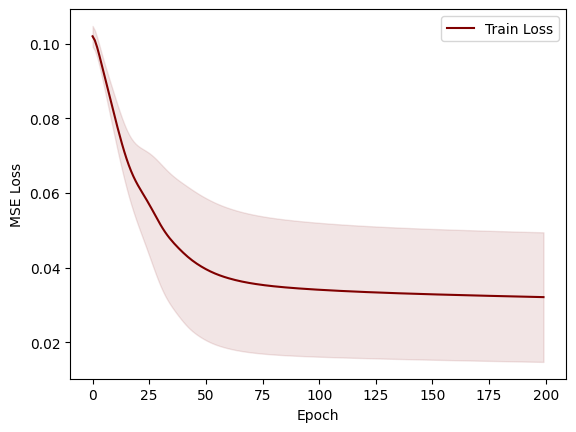

Name: GCNRegression
Number of parameters: 8577
Number of layers: 4
Signature depth: 1
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [05:31<00:00,  1.21it/s]

MSE: 0.0230 ± 0.0180, MAE: 0.1221 ± 0.0493, RMSE: 0.1425 ± 0.0522


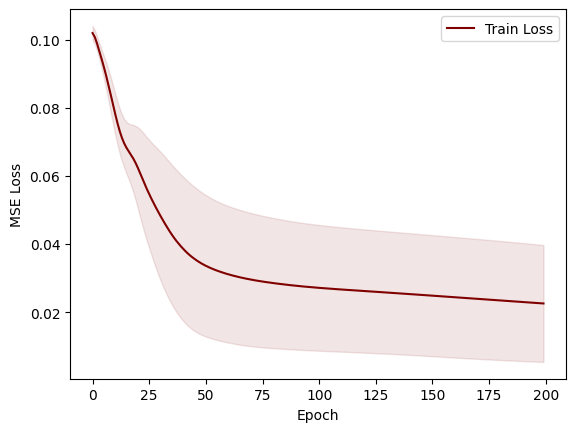

Name: GCNRegression
Number of parameters: 12737
Number of layers: 5
Signature depth: 1
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [06:51<00:00,  1.03s/it]

MSE: 0.0179 ± 0.0174, MAE: 0.1040 ± 0.0493, RMSE: 0.1230 ± 0.0523


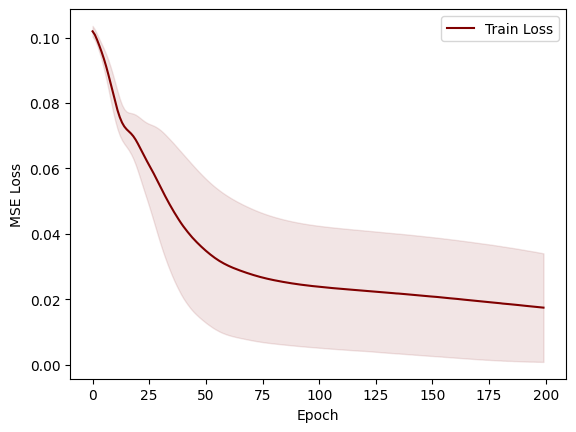

Signature depth: 2


100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


Name: GCNRegression
Number of parameters: 7
Number of layers: 1
Signature depth: 2
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [00:39<00:00, 10.02it/s]

MSE: 0.0799 ± 0.0114, MAE: 0.2381 ± 0.0252, RMSE: 0.2820 ± 0.0202


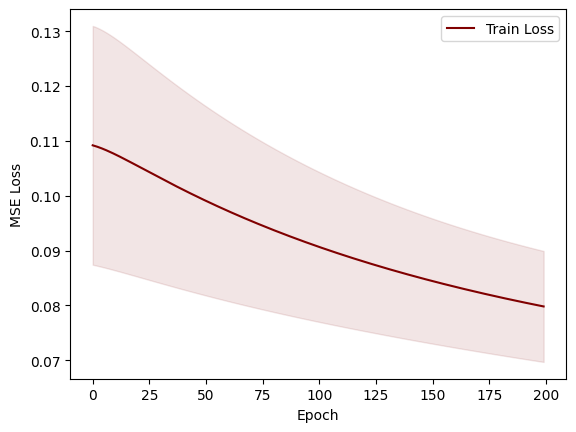

Name: GCNRegression
Number of parameters: 513
Number of layers: 2
Signature depth: 2
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [02:17<00:00,  2.91it/s]

MSE: 0.0391 ± 0.0143, MAE: 0.1665 ± 0.0325, RMSE: 0.1945 ± 0.0352


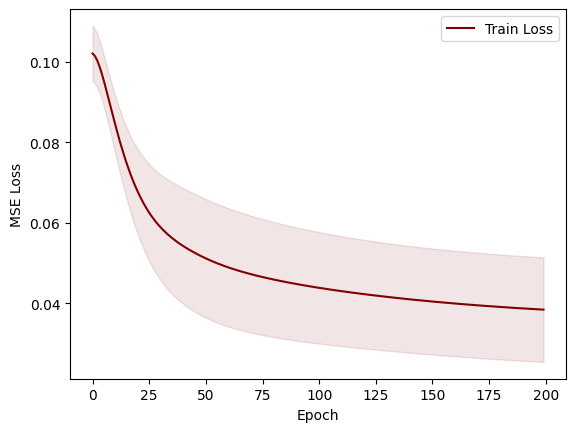

Name: GCNRegression
Number of parameters: 4673
Number of layers: 3
Signature depth: 2
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [03:50<00:00,  1.73it/s]

MSE: 0.0215 ± 0.0116, MAE: 0.1202 ± 0.0352, RMSE: 0.1422 ± 0.0365


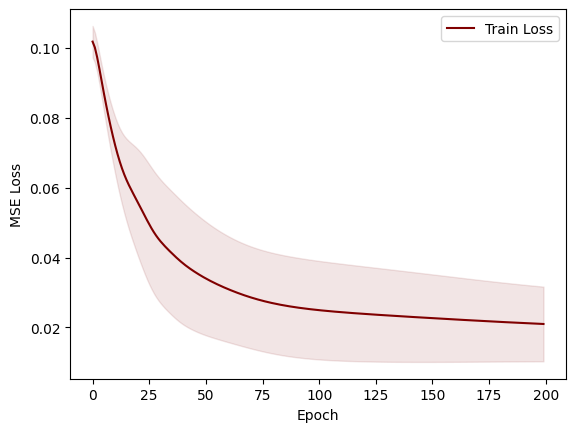

Name: GCNRegression
Number of parameters: 8833
Number of layers: 4
Signature depth: 2
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [05:20<00:00,  1.25it/s]

MSE: 0.0114 ± 0.0049, MAE: 0.0849 ± 0.0193, RMSE: 0.1043 ± 0.0221


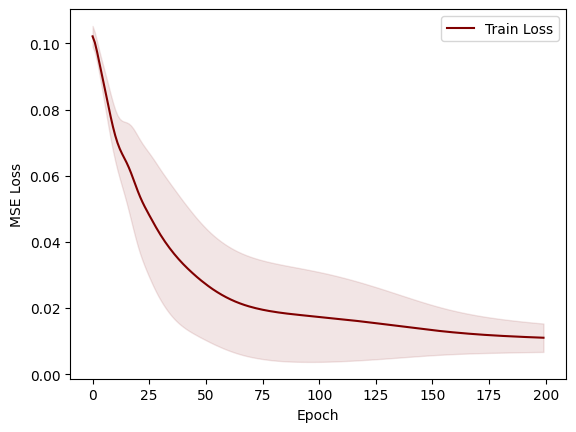

Name: GCNRegression
Number of parameters: 12993
Number of layers: 5
Signature depth: 2
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [06:50<00:00,  1.03s/it]

MSE: 0.0087 ± 0.0045, MAE: 0.0734 ± 0.0176, RMSE: 0.0909 ± 0.0206


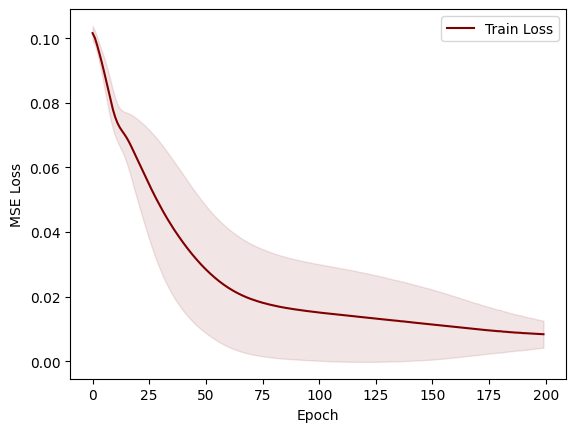

Signature depth: 3


100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


Name: GCNRegression
Number of parameters: 15
Number of layers: 1
Signature depth: 3
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [00:39<00:00, 10.21it/s]


MSE: 0.0755 ± 0.0109, MAE: 0.2278 ± 0.0246, RMSE: 0.2740 ± 0.0202


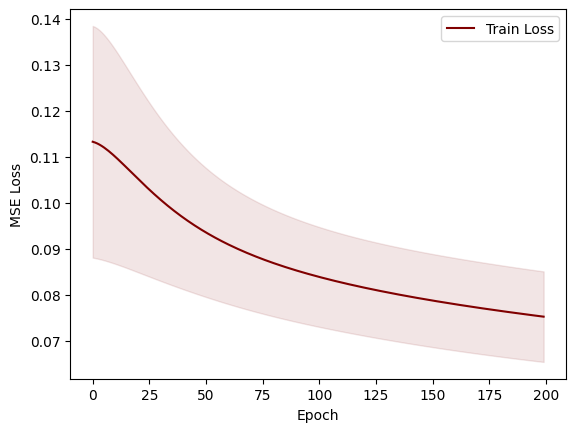

Name: GCNRegression
Number of parameters: 1025
Number of layers: 2
Signature depth: 3
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [02:13<00:00,  2.99it/s]

MSE: 0.0358 ± 0.0129, MAE: 0.1591 ± 0.0308, RMSE: 0.1863 ± 0.0330


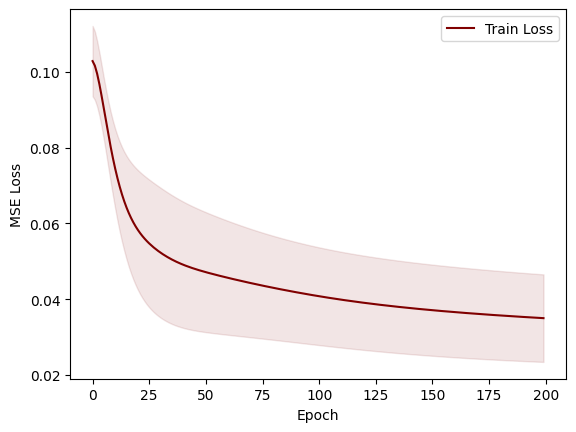

Name: GCNRegression
Number of parameters: 5185
Number of layers: 3
Signature depth: 3
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [03:47<00:00,  1.76it/s]

MSE: 0.0181 ± 0.0085, MAE: 0.1099 ± 0.0282, RMSE: 0.1311 ± 0.0296


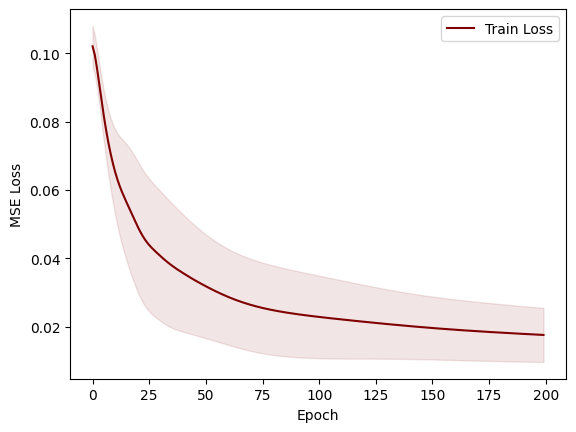

Name: GCNRegression
Number of parameters: 9345
Number of layers: 4
Signature depth: 3
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [05:11<00:00,  1.28it/s]

MSE: 0.0099 ± 0.0040, MAE: 0.0792 ± 0.0168, RMSE: 0.0977 ± 0.0191


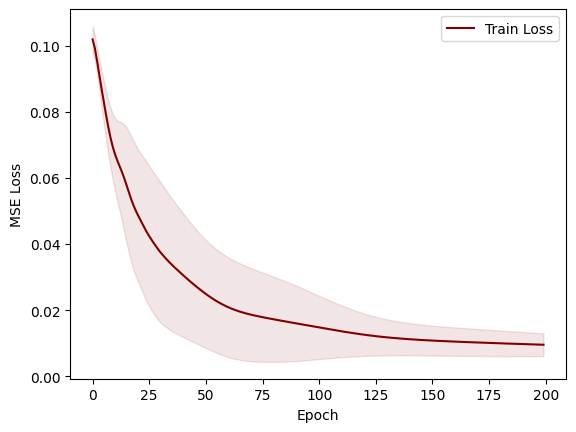

Name: GCNRegression
Number of parameters: 13505
Number of layers: 5
Signature depth: 3
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [06:46<00:00,  1.02s/it]

MSE: 0.0075 ± 0.0025, MAE: 0.0689 ± 0.0111, RMSE: 0.0856 ± 0.0137


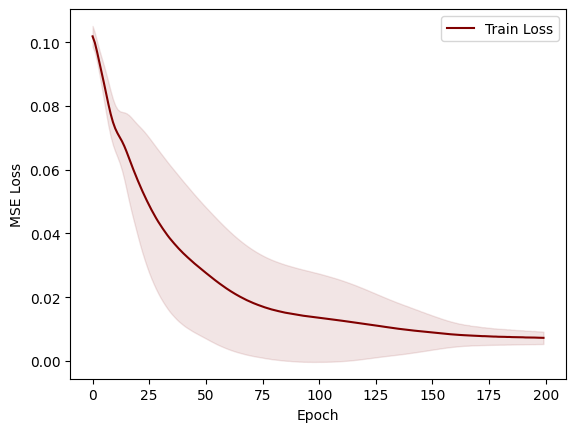

Signature depth: 4


100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


Name: GCNRegression
Number of parameters: 31
Number of layers: 1
Signature depth: 4
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [00:39<00:00, 10.05it/s]

MSE: 0.0689 ± 0.0103, MAE: 0.2151 ± 0.0236, RMSE: 0.2617 ± 0.0198


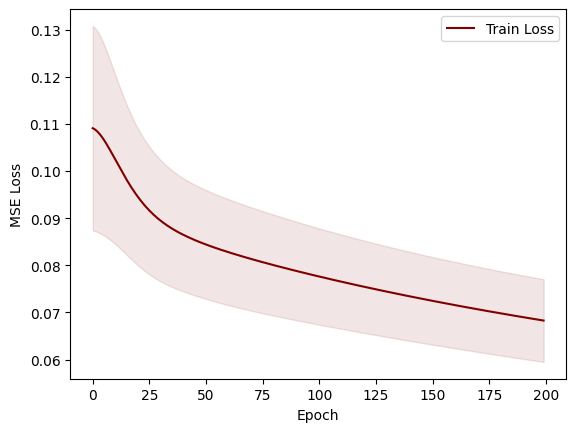

Name: GCNRegression
Number of parameters: 2049
Number of layers: 2
Signature depth: 4
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [02:18<00:00,  2.88it/s]

MSE: 0.0247 ± 0.0080, MAE: 0.1330 ± 0.0234, RMSE: 0.1551 ± 0.0251


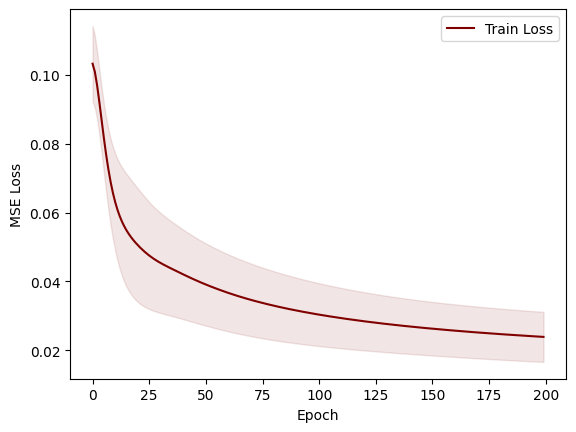

Name: GCNRegression
Number of parameters: 6209
Number of layers: 3
Signature depth: 4
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [03:56<00:00,  1.69it/s]

MSE: 0.0127 ± 0.0058, MAE: 0.0915 ± 0.0229, RMSE: 0.1098 ± 0.0244


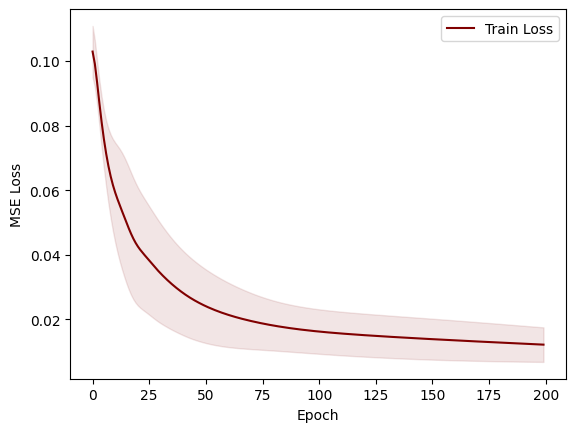

Name: GCNRegression
Number of parameters: 10369
Number of layers: 4
Signature depth: 4
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [05:29<00:00,  1.22it/s]

MSE: 0.0080 ± 0.0030, MAE: 0.0713 ± 0.0135, RMSE: 0.0882 ± 0.0159


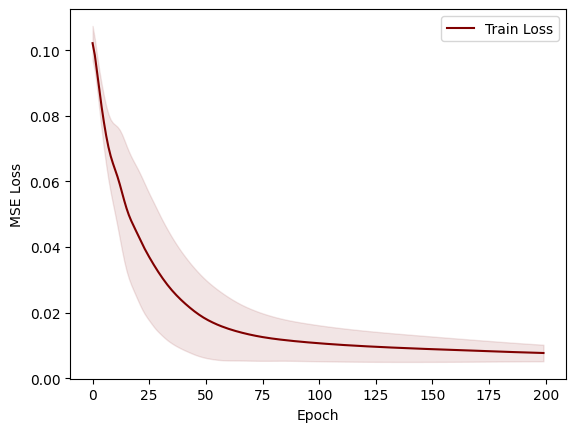

Name: GCNRegression
Number of parameters: 14529
Number of layers: 5
Signature depth: 4
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [07:02<00:00,  1.06s/it]

MSE: 0.0069 ± 0.0025, MAE: 0.0657 ± 0.0109, RMSE: 0.0818 ± 0.0135


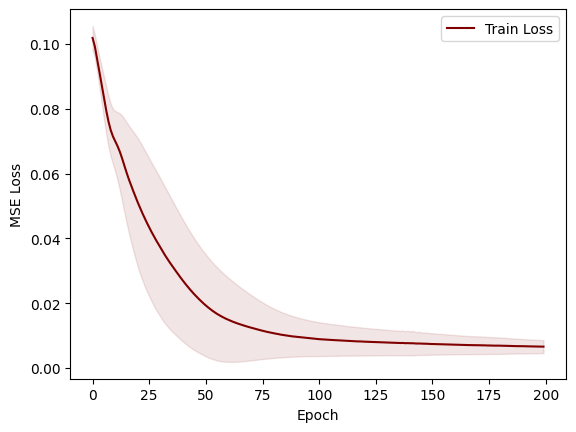

Signature depth: 5


100%|██████████| 20/20 [00:31<00:00,  1.55s/it]


Name: GCNRegression
Number of parameters: 63
Number of layers: 1
Signature depth: 5
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [00:40<00:00,  9.90it/s]

MSE: 0.0629 ± 0.0103, MAE: 0.2023 ± 0.0225, RMSE: 0.2499 ± 0.0207


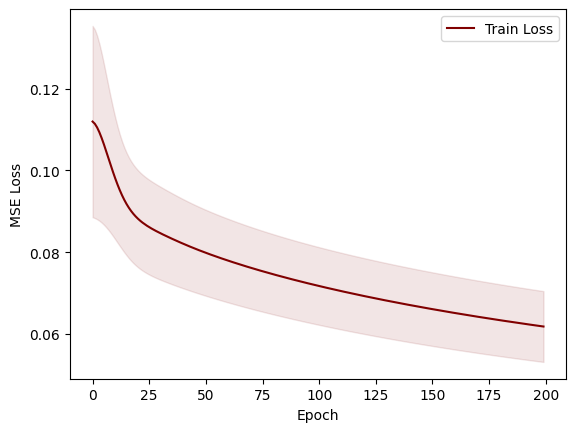

Name: GCNRegression
Number of parameters: 4097
Number of layers: 2
Signature depth: 5
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [02:21<00:00,  2.82it/s]

MSE: 0.0223 ± 0.0073, MAE: 0.1260 ± 0.0225, RMSE: 0.1474 ± 0.0239


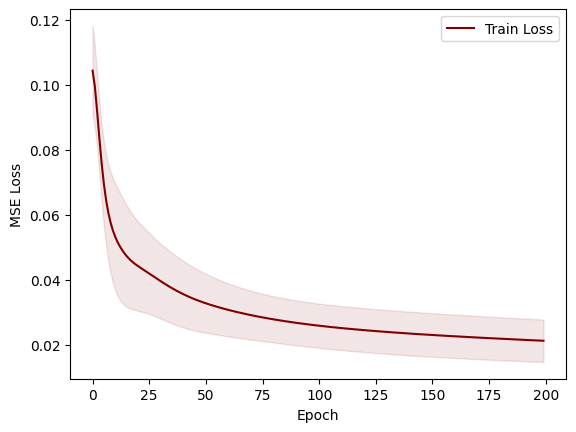

Name: GCNRegression
Number of parameters: 8257
Number of layers: 3
Signature depth: 5
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [03:58<00:00,  1.68it/s]

MSE: 0.0118 ± 0.0053, MAE: 0.0877 ± 0.0213, RMSE: 0.1060 ± 0.0230


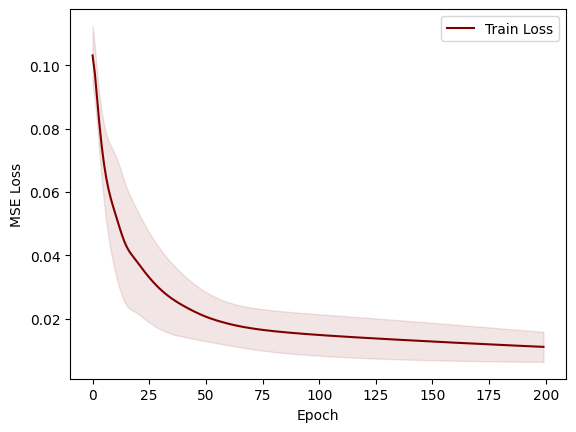

Name: GCNRegression
Number of parameters: 12417
Number of layers: 4
Signature depth: 5
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [05:28<00:00,  1.22it/s]

MSE: 0.0079 ± 0.0031, MAE: 0.0704 ± 0.0139, RMSE: 0.0874 ± 0.0162


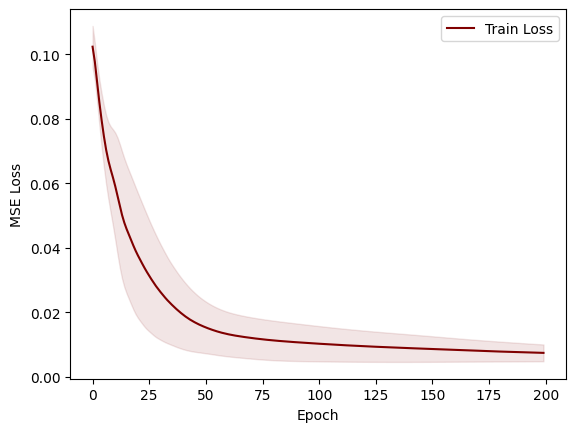

Name: GCNRegression
Number of parameters: 16577
Number of layers: 5
Signature depth: 5
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [07:09<00:00,  1.07s/it]

MSE: 0.0072 ± 0.0033, MAE: 0.0671 ± 0.0148, RMSE: 0.0832 ± 0.0172


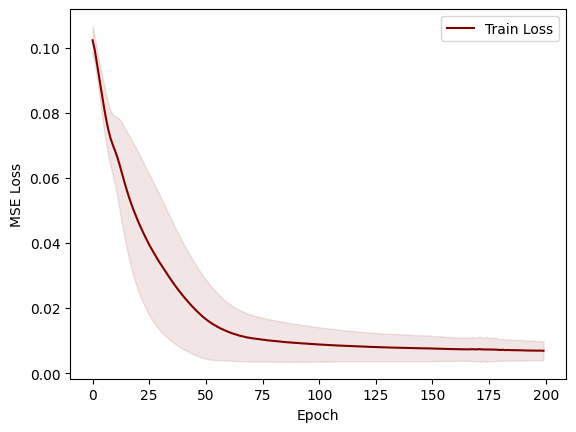

In [4]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from signatory import signature_channels


import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GCNRegression, MLPRegression
from pygsig.graph import  split_nodes

import importlib
importlib.reload(pygsig.models)
importlib.reload(pygsig.signature)
importlib.reload(pygsig.graph)

num_nodes = seq_dataset[0].num_nodes
dim = seq_dataset[0].num_node_features
out_channels = 1
num_splits = 5 # split the nodes
num_runs = len(seq_dataset)
num_trials = 4
num_epochs = 200

# hyperparameters
learning_rate = 1e-3
lasso = 0
num_hidden = 64

print_during_training = False

all_models = []
all_model_parameters = []
all_model_depths = []
all_model_layers = []
all_models_mse = []
all_models_mae = []
all_models_rmse = []

# create models 
max_depth = 5
max_layers = 5
for depth in range(1,max_depth+1):
    print(f'Signature depth: {depth}')
    dataset = []
    for seq in tqdm(seq_dataset):
        signature_transform = SignatureFeatures(sig_depth=depth, normalize=True, log_signature=False,lead_lag=True)
        dataset.append(signature_transform(seq))
    for num_layers in range(max_layers):
        in_channels = signature_channels(2*dim,depth)
        model = GCNRegression(num_channels=[in_channels]+num_layers*[num_hidden]+[out_channels])
        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f'Name: {model._get_name()}')
        print(f"Number of parameters: {num_params}")
        print(f"Number of layers: {num_layers+1}")
        print(f"Signature depth: {depth}")
        print(f"Splits: {num_splits}, Trials: {num_trials}, Runs: {num_runs}, Epochs: {num_epochs}")
        all_model_parameters.append(num_params)
        all_model_layers.append(num_layers+1)
        all_model_depths.append(depth)
        
        criterion = nn.MSELoss() # loss function
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=lasso) 
        train_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs]) 
        eval_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs])
        mse = np.zeros([num_splits, num_runs, num_trials])
        mae = np.zeros([num_splits, num_runs, num_trials])
        rmse = np.zeros([num_splits, num_runs, num_trials])

        with tqdm(total=num_splits*num_runs*num_trials, disable=print_during_training) as pbar:
            splits = split_nodes(num_nodes, num_splits,test_ratio=1.0,seed=29)
            for split in range(num_splits):
                train_indices, eval_indices, test_indices = splits[split]
                train_mask = torch.zeros(num_nodes, dtype=torch.bool)
                eval_mask = torch.zeros(num_nodes, dtype=torch.bool)
                test_mask = torch.zeros(num_nodes, dtype=torch.bool)
                train_mask[train_indices] = True
                eval_mask[eval_indices] = True
                test_mask[test_indices] = True
                for run, data in enumerate(dataset):
                    for trial in range(num_trials):
                        model.reset_parameters()
                        for epoch in range(num_epochs):
                            # train
                            model.train()
                            optimizer.zero_grad()
                            out = model(data.x, data.edge_index)
                            train_loss = criterion(out[train_mask], data.y[train_mask])
                            train_loss.backward()
                            optimizer.step()
                            # evaluate
                            model.eval()
                            with torch.no_grad():
                                eval_loss = criterion(out[eval_mask], data.y[eval_mask])
                                train_losses[split, run, trial, epoch] = train_loss.item()
                                eval_losses[split, run, trial, epoch] = eval_loss.item()
                            if epoch % 10 == 0 and print_during_training:
                                print(f'Split {split}, Run {run}, Trial {trial}, Epoch {epoch}, Train MSE Loss: {train_loss.item():.4f}, Evaulation MSE Loss: {eval_loss.item():.4f}')
                        pbar.update(1)
                        # compute the errors on the testing loss after the last epoch
                        with torch.no_grad():
                            out = model(data.x, data.edge_index)
                            mse[split, run, trial] = mean_squared_error(data.y[test_mask], out[test_mask])
                            mae[split, run, trial] = mean_absolute_error(data.y[test_mask], out[test_mask])
                            rmse[split, run, trial] = np.sqrt(mean_squared_error(data.y[test_mask], out[test_mask]))

        print(f'MSE: {np.mean(mse):.4f} ± {np.std(mse):.4f}, MAE: {np.mean(mae):.4f} ± {np.std(mae):.4f}, RMSE: {np.mean(rmse):.4f} ± {np.std(rmse):.4f}')  
        all_models_mse.append(mse)
        all_models_mae.append(mae)
        all_models_rmse.append(rmse)

        # Plotting
        avg_train_losses = np.mean(train_losses, axis=(0,1,2))
        avg_eval_losses = np.mean(eval_losses, axis=(0,1,2))
        std_train_losses = np.std(train_losses, axis=(0,1,2))
        std_eval_losses = np.std(eval_losses, axis=(0,1,2))
        
        plt.figure()
        plt.plot(avg_train_losses,  label='Train Loss', color='maroon')
        # plt.plot(avg_eval_losses,  label='Evaluation Loss', color='navy')
        plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.1, color='maroon')
        # plt.fill_between(range(num_epochs), avg_eval_losses - std_eval_losses, avg_eval_losses + std_eval_losses, alpha=0.1,color='navy')
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.legend()
        plt.show()

Dataframe with all results

In [28]:
import pandas as pd
import numpy as np

# Collecting data in a list of dictionaries
data = []
# Populate the data list
for idx in range(len(all_models_mse)):
    for split in range(all_models_mse[0].shape[0]):
        for run in range(all_models_mse[0].shape[1]):
            for trial in range(all_models_mse[0].shape[2]):
                # Extract MAE and RMSE for the current model, split, and run
                mae_value = all_models_mae[idx][split, run, trial]
                mse_value = all_models_mse[idx][split, run, trial]
                rmse_value = all_models_rmse[idx][split, run, trial]
                num_layers = all_model_layers[idx]
                depth = all_model_depths[idx]
                num_params = all_model_parameters[idx]
                
                # Append the data as a dictionary
                data.append({
                    'SigDepth': depth,
                    'NumLayers': num_layers,
                    'NumParams': num_params,
                    'Split': split,
                    'Run': run,
                    'Trial': trial,
                    'MAE': mae_value,
                    'MSE': mse_value,
                    'RMSE': rmse_value
                })

# Create the DataFrame from the list of dictionaries
df = pd.DataFrame(data)
df.to_json('results/brownian_gcn_1d_3b.json')

### MLP

Signature depth: 1


100%|██████████| 20/20 [00:19<00:00,  1.00it/s]


Name: MLPRegression
Number of parameters: 3
Number of layers: 1
Signature depth: 1
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [00:15<00:00, 25.18it/s]


MSE: 0.0988 ± 0.0239, MAE: 0.2642 ± 0.0306, RMSE: 0.3122 ± 0.0369


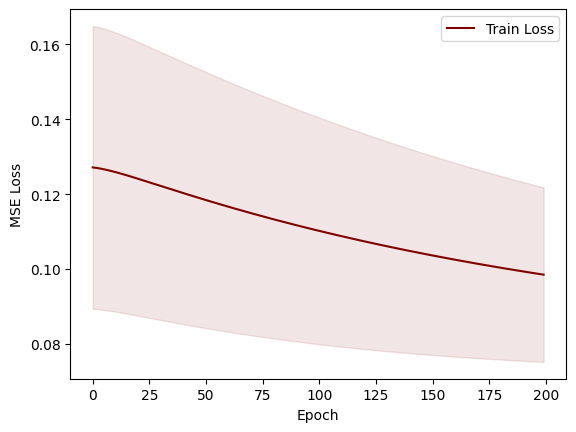

Name: MLPRegression
Number of parameters: 257
Number of layers: 2
Signature depth: 1
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [00:23<00:00, 16.76it/s]

MSE: 0.0726 ± 0.0095, MAE: 0.2272 ± 0.0236, RMSE: 0.2689 ± 0.0171


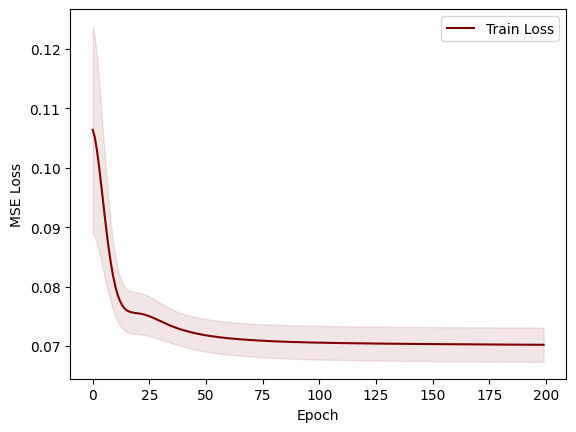

Name: MLPRegression
Number of parameters: 4417
Number of layers: 3
Signature depth: 1
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [00:33<00:00, 11.94it/s]


MSE: 0.0730 ± 0.0095, MAE: 0.2280 ± 0.0234, RMSE: 0.2696 ± 0.0171


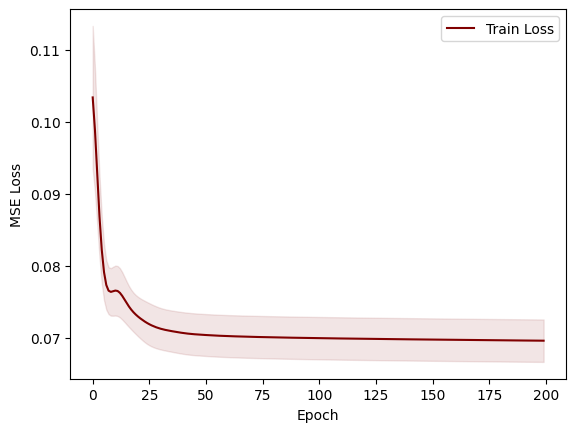

Name: MLPRegression
Number of parameters: 8577
Number of layers: 4
Signature depth: 1
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [00:43<00:00,  9.29it/s]

MSE: 0.0733 ± 0.0096, MAE: 0.2288 ± 0.0231, RMSE: 0.2702 ± 0.0172


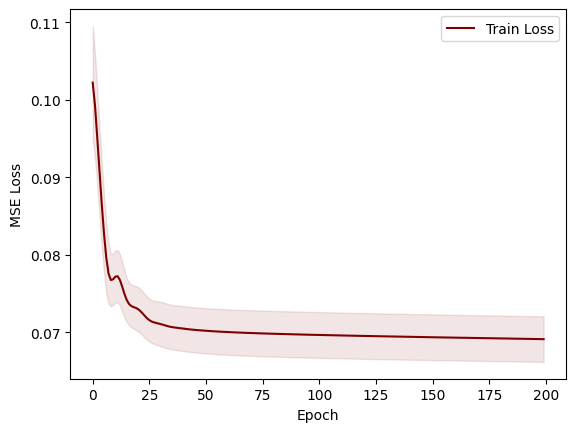

Name: MLPRegression
Number of parameters: 12737
Number of layers: 5
Signature depth: 1
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [00:51<00:00,  7.75it/s]

MSE: 0.0738 ± 0.0096, MAE: 0.2300 ± 0.0229, RMSE: 0.2710 ± 0.0172


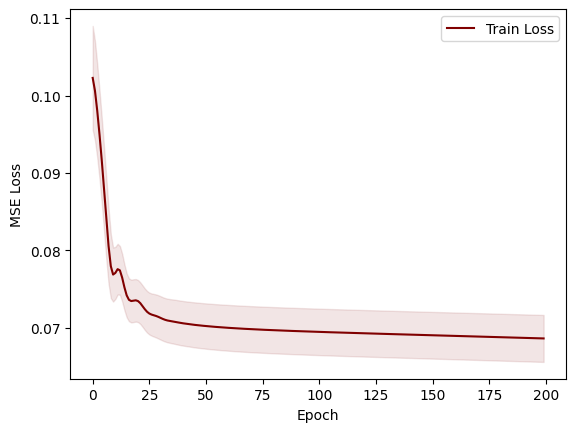

Signature depth: 2


100%|██████████| 20/20 [00:25<00:00,  1.30s/it]


Name: MLPRegression
Number of parameters: 7
Number of layers: 1
Signature depth: 2
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [00:15<00:00, 25.20it/s]


MSE: 0.0879 ± 0.0124, MAE: 0.2538 ± 0.0199, RMSE: 0.2958 ± 0.0206


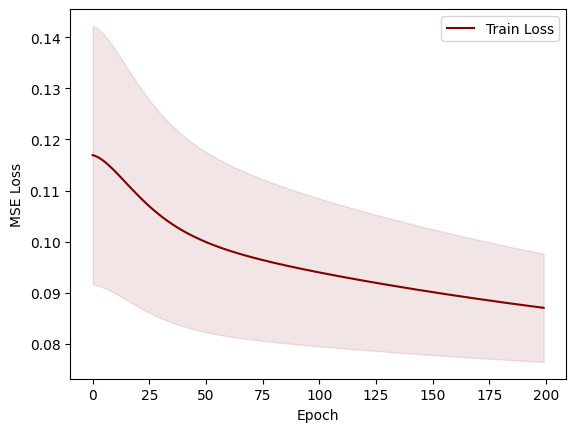

Name: MLPRegression
Number of parameters: 513
Number of layers: 2
Signature depth: 2
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [00:23<00:00, 16.73it/s]

MSE: 0.0729 ± 0.0097, MAE: 0.2274 ± 0.0238, RMSE: 0.2694 ± 0.0173


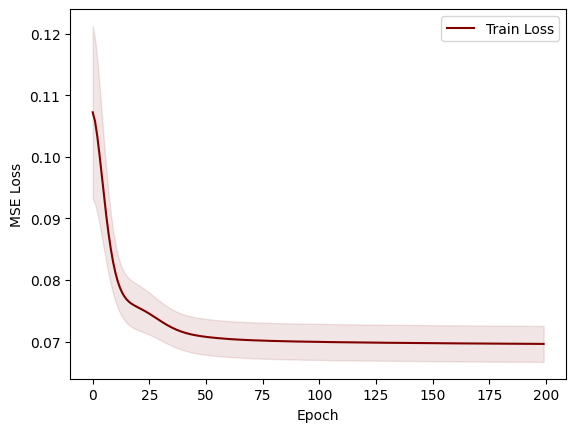

Name: MLPRegression
Number of parameters: 4673
Number of layers: 3
Signature depth: 2
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [00:34<00:00, 11.76it/s]


MSE: 0.0734 ± 0.0097, MAE: 0.2287 ± 0.0232, RMSE: 0.2703 ± 0.0173


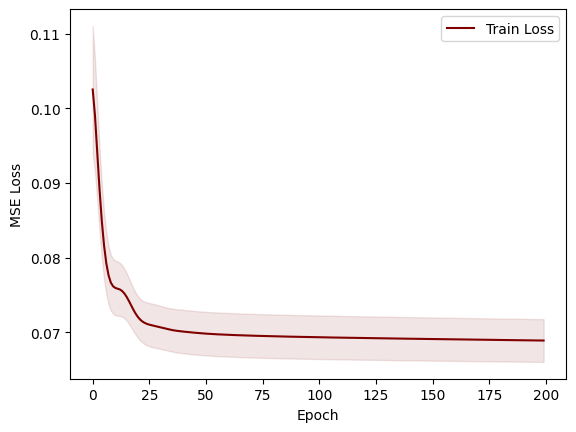

Name: MLPRegression
Number of parameters: 8833
Number of layers: 4
Signature depth: 2
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [00:42<00:00,  9.35it/s]

MSE: 0.0739 ± 0.0096, MAE: 0.2302 ± 0.0228, RMSE: 0.2713 ± 0.0172


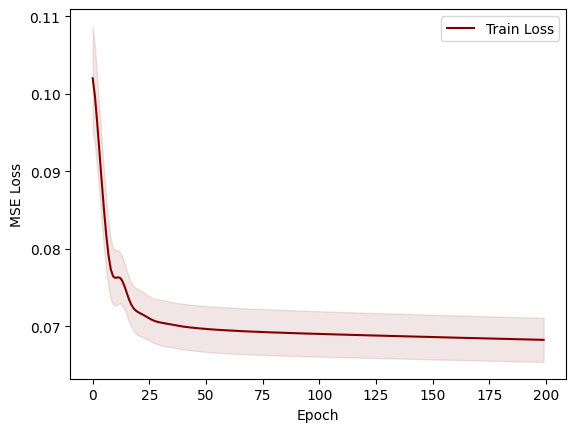

Name: MLPRegression
Number of parameters: 12993
Number of layers: 5
Signature depth: 2
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [00:52<00:00,  7.69it/s]

MSE: 0.0746 ± 0.0096, MAE: 0.2318 ± 0.0224, RMSE: 0.2725 ± 0.0172


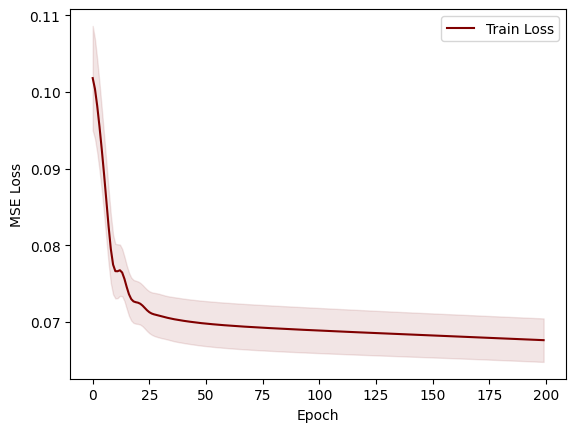

Signature depth: 3


100%|██████████| 20/20 [00:27<00:00,  1.38s/it]


Name: MLPRegression
Number of parameters: 15
Number of layers: 1
Signature depth: 3
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [00:15<00:00, 25.28it/s]


MSE: 0.0865 ± 0.0092, MAE: 0.2528 ± 0.0155, RMSE: 0.2936 ± 0.0155


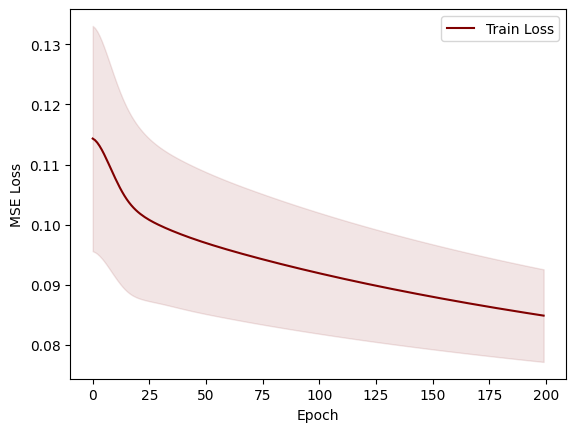

Name: MLPRegression
Number of parameters: 1025
Number of layers: 2
Signature depth: 3
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [00:24<00:00, 16.03it/s]

MSE: 0.0691 ± 0.0103, MAE: 0.2228 ± 0.0235, RMSE: 0.2622 ± 0.0191


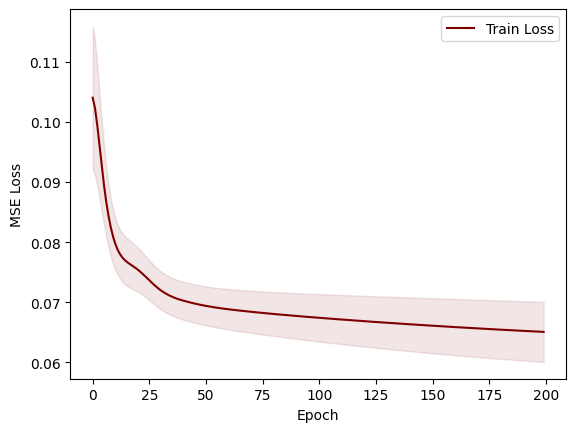

Name: MLPRegression
Number of parameters: 5185
Number of layers: 3
Signature depth: 3
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [00:34<00:00, 11.45it/s]


MSE: 0.0680 ± 0.0109, MAE: 0.2210 ± 0.0231, RMSE: 0.2599 ± 0.0205


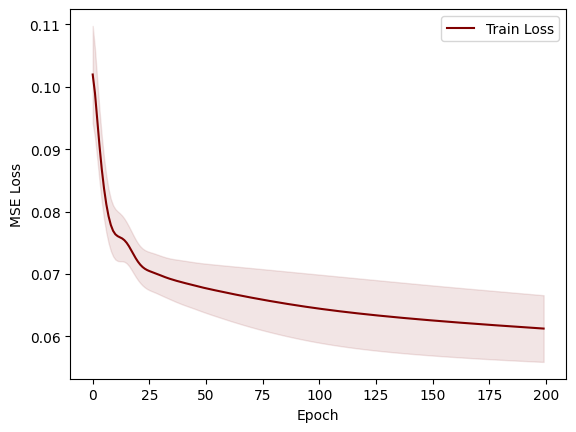

Name: MLPRegression
Number of parameters: 9345
Number of layers: 4
Signature depth: 3
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [00:44<00:00,  9.08it/s]

MSE: 0.0681 ± 0.0109, MAE: 0.2205 ± 0.0226, RMSE: 0.2601 ± 0.0205


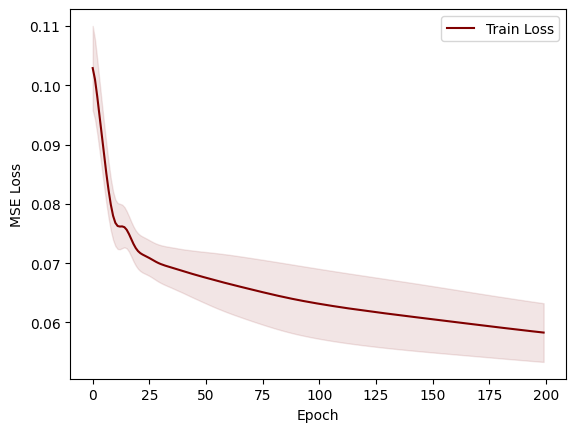

Name: MLPRegression
Number of parameters: 13505
Number of layers: 5
Signature depth: 3
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [00:51<00:00,  7.75it/s]

MSE: 0.0687 ± 0.0111, MAE: 0.2211 ± 0.0222, RMSE: 0.2614 ± 0.0208


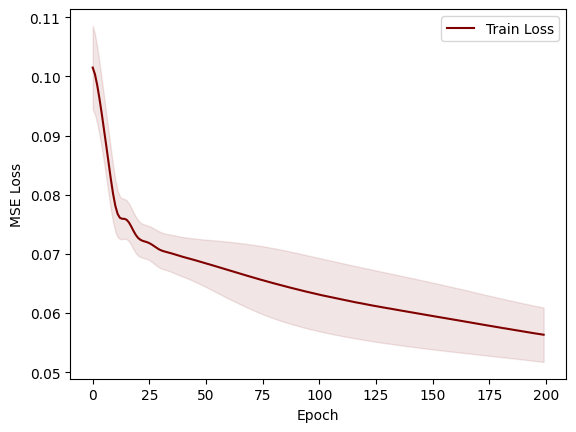

Signature depth: 4


100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


Name: MLPRegression
Number of parameters: 31
Number of layers: 1
Signature depth: 4
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [00:15<00:00, 25.18it/s]


MSE: 0.0806 ± 0.0089, MAE: 0.2405 ± 0.0157, RMSE: 0.2834 ± 0.0154


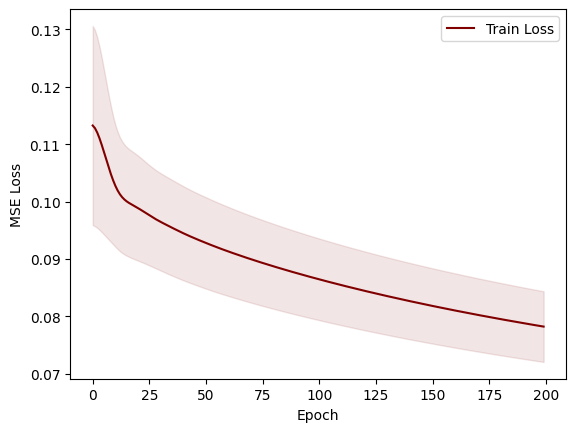

Name: MLPRegression
Number of parameters: 2049
Number of layers: 2
Signature depth: 4
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [00:23<00:00, 16.87it/s]

MSE: 0.0608 ± 0.0097, MAE: 0.2086 ± 0.0205, RMSE: 0.2459 ± 0.0192


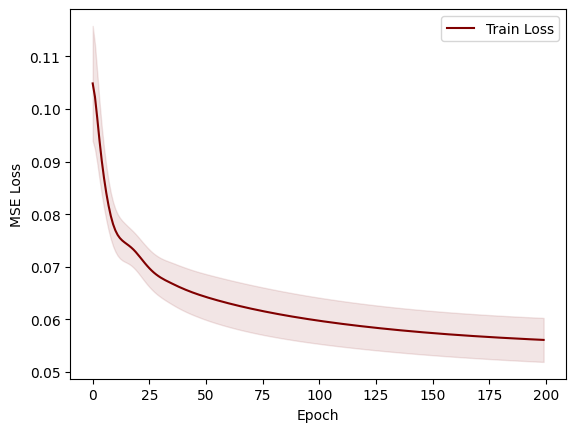

Name: MLPRegression
Number of parameters: 6209
Number of layers: 3
Signature depth: 4
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [00:33<00:00, 11.95it/s]

MSE: 0.0601 ± 0.0105, MAE: 0.2046 ± 0.0203, RMSE: 0.2443 ± 0.0212


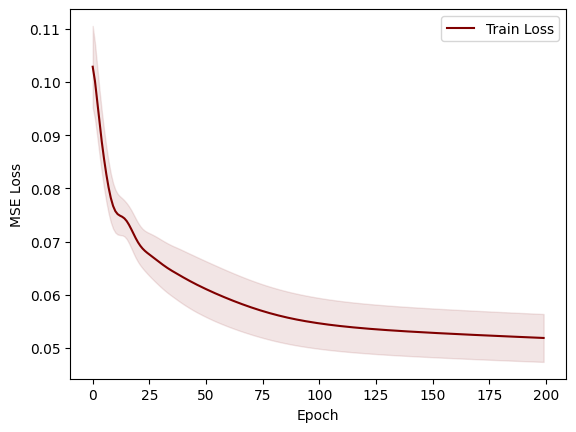

Name: MLPRegression
Number of parameters: 10369
Number of layers: 4
Signature depth: 4
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [00:42<00:00,  9.39it/s]

MSE: 0.0612 ± 0.0106, MAE: 0.2050 ± 0.0197, RMSE: 0.2464 ± 0.0211


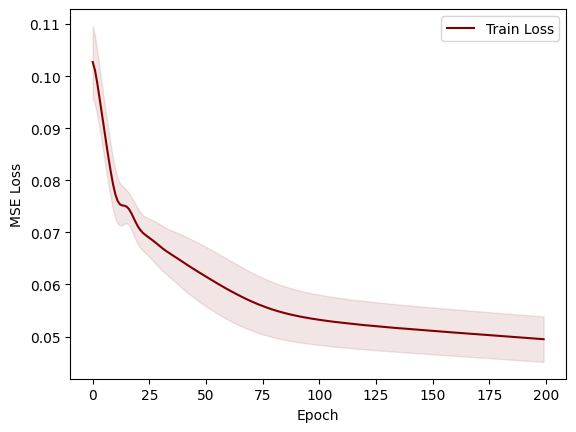

Name: MLPRegression
Number of parameters: 14529
Number of layers: 5
Signature depth: 4
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [00:51<00:00,  7.75it/s]

MSE: 0.0626 ± 0.0110, MAE: 0.2070 ± 0.0197, RMSE: 0.2493 ± 0.0214


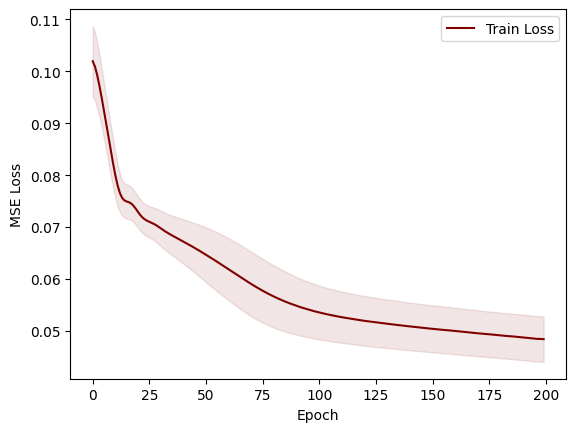

Signature depth: 5


100%|██████████| 20/20 [00:30<00:00,  1.52s/it]


Name: MLPRegression
Number of parameters: 63
Number of layers: 1
Signature depth: 5
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [00:15<00:00, 25.87it/s]


MSE: 0.0770 ± 0.0092, MAE: 0.2330 ± 0.0175, RMSE: 0.2770 ± 0.0162


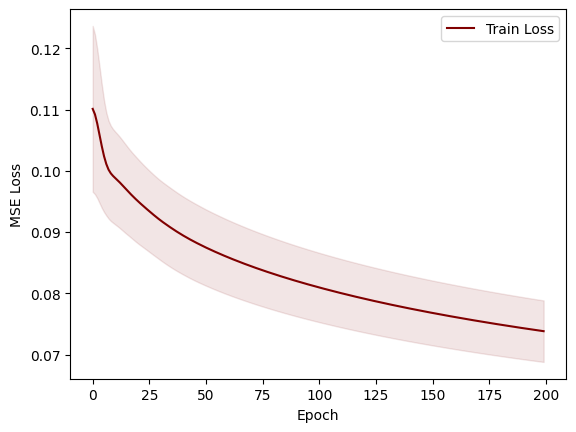

Name: MLPRegression
Number of parameters: 4097
Number of layers: 2
Signature depth: 5
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [00:28<00:00, 14.25it/s]

MSE: 0.0613 ± 0.0095, MAE: 0.2087 ± 0.0201, RMSE: 0.2469 ± 0.0188


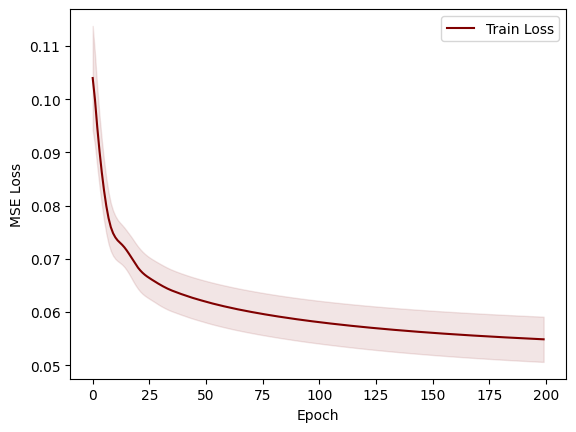

Name: MLPRegression
Number of parameters: 8257
Number of layers: 3
Signature depth: 5
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [00:36<00:00, 11.09it/s]

MSE: 0.0606 ± 0.0104, MAE: 0.2046 ± 0.0196, RMSE: 0.2454 ± 0.0208


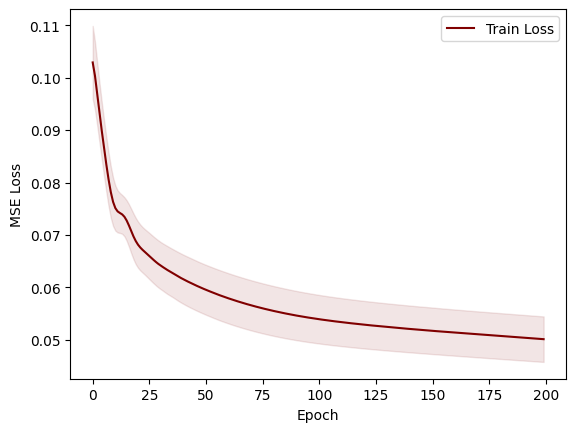

Name: MLPRegression
Number of parameters: 12417
Number of layers: 4
Signature depth: 5
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [00:47<00:00,  8.45it/s]

MSE: 0.0614 ± 0.0101, MAE: 0.2048 ± 0.0185, RMSE: 0.2470 ± 0.0200


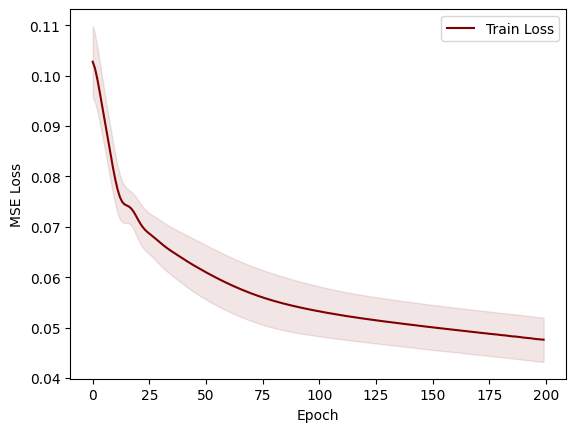

Name: MLPRegression
Number of parameters: 16577
Number of layers: 5
Signature depth: 5
Splits: 5, Trials: 4, Runs: 20, Epochs: 200


100%|██████████| 400/400 [00:54<00:00,  7.39it/s]

MSE: 0.0625 ± 0.0106, MAE: 0.2066 ± 0.0190, RMSE: 0.2491 ± 0.0208


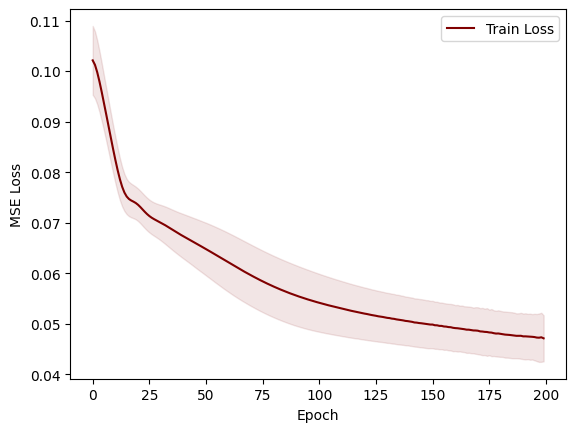

In [43]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from signatory import signature_channels


import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GCNRegression, MLPRegression
from pygsig.graph import  split_nodes

import importlib
importlib.reload(pygsig.models)
importlib.reload(pygsig.signature)
importlib.reload(pygsig.graph)

num_nodes = seq_dataset[0].num_nodes
dim = seq_dataset[0].num_node_features
out_channels = 1
num_splits = 5 # split the nodes
num_runs = len(seq_dataset)
num_trials = 4
num_epochs = 200

# hyperparameters
learning_rate = 1e-3
lasso = 0
num_hidden = 64

print_during_training = False

all_models = []
all_model_parameters = []
all_model_depths = []
all_model_layers = []
all_models_mse = []
all_models_mae = []
all_models_rmse = []

# create models 
max_depth = 5
max_layers = 5
for depth in range(1,max_depth+1):
    print(f'Signature depth: {depth}')
    dataset = []
    for seq in tqdm(seq_dataset):
        signature_transform = SignatureFeatures(sig_depth=depth, normalize=True, log_signature=False,lead_lag=True)
        dataset.append(signature_transform(seq))
    for num_layers in range(max_layers):
        in_channels = signature_channels(2*dim,depth)
        model = MLPRegression(num_channels=[in_channels]+num_layers*[num_hidden]+[out_channels])
        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f'Name: {model._get_name()}')
        print(f"Number of parameters: {num_params}")
        print(f"Number of layers: {num_layers+1}")
        print(f"Signature depth: {depth}")
        print(f"Splits: {num_splits}, Trials: {num_trials}, Runs: {num_runs}, Epochs: {num_epochs}")
        all_model_parameters.append(num_params)
        all_model_layers.append(num_layers+1)
        all_model_depths.append(depth)
        
        criterion = nn.MSELoss() # loss function
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=lasso) 
        train_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs]) 
        eval_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs])
        mse = np.zeros([num_splits, num_runs, num_trials])
        mae = np.zeros([num_splits, num_runs, num_trials])
        rmse = np.zeros([num_splits, num_runs, num_trials])

        with tqdm(total=num_splits*num_runs*num_trials, disable=print_during_training) as pbar:
            splits = split_nodes(num_nodes, num_splits,test_ratio=1.0,seed=29)
            for split in range(num_splits):
                train_indices, eval_indices, test_indices = splits[split]
                train_mask = torch.zeros(num_nodes, dtype=torch.bool)
                eval_mask = torch.zeros(num_nodes, dtype=torch.bool)
                test_mask = torch.zeros(num_nodes, dtype=torch.bool)
                train_mask[train_indices] = True
                eval_mask[eval_indices] = True
                test_mask[test_indices] = True
                for run, data in enumerate(dataset):
                    for trial in range(num_trials):
                        model.reset_parameters()
                        for epoch in range(num_epochs):
                            # train
                            model.train()
                            optimizer.zero_grad()
                            out = model(data.x, data.edge_index)
                            train_loss = criterion(out[train_mask], data.y[train_mask])
                            train_loss.backward()
                            optimizer.step()
                            # evaluate
                            model.eval()
                            with torch.no_grad():
                                eval_loss = criterion(out[eval_mask], data.y[eval_mask])
                                train_losses[split, run, trial, epoch] = train_loss.item()
                                eval_losses[split, run, trial, epoch] = eval_loss.item()
                            if epoch % 10 == 0 and print_during_training:
                                print(f'Split {split}, Run {run}, Trial {trial}, Epoch {epoch}, Train MSE Loss: {train_loss.item():.4f}, Evaulation MSE Loss: {eval_loss.item():.4f}')
                        pbar.update(1)
                        # compute the errors on the testing loss after the last epoch
                        with torch.no_grad():
                            out = model(data.x, data.edge_index)
                            mse[split, run, trial] = mean_squared_error(data.y[test_mask], out[test_mask])
                            mae[split, run, trial] = mean_absolute_error(data.y[test_mask], out[test_mask])
                            rmse[split, run, trial] = np.sqrt(mean_squared_error(data.y[test_mask], out[test_mask]))

        print(f'MSE: {np.mean(mse):.4f} ± {np.std(mse):.4f}, MAE: {np.mean(mae):.4f} ± {np.std(mae):.4f}, RMSE: {np.mean(rmse):.4f} ± {np.std(rmse):.4f}')  
        all_models_mse.append(mse)
        all_models_mae.append(mae)
        all_models_rmse.append(rmse)

        # Plotting
        avg_train_losses = np.mean(train_losses, axis=(0,1,2))
        avg_eval_losses = np.mean(eval_losses, axis=(0,1,2))
        std_train_losses = np.std(train_losses, axis=(0,1,2))
        std_eval_losses = np.std(eval_losses, axis=(0,1,2))
        
        plt.figure()
        plt.plot(avg_train_losses,  label='Train Loss', color='maroon')
        # plt.plot(avg_eval_losses,  label='Evaluation Loss', color='navy')
        plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.1, color='maroon')
        # plt.fill_between(range(num_epochs), avg_eval_losses - std_eval_losses, avg_eval_losses + std_eval_losses, alpha=0.1,color='navy')
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.legend()
        plt.show()

Dataframe with all results

In [47]:
import pandas as pd
import numpy as np

# Collecting data in a list of dictionaries
data = []
# Populate the data list
for idx in range(len(all_models_mse)):
    for split in range(all_models_mse[0].shape[0]):
        for run in range(all_models_mse[0].shape[1]):
            for trial in range(all_models_mse[0].shape[2]):
                # Extract MAE and RMSE for the current model, split, and run
                mae_value = all_models_mae[idx][split, run, trial]
                mse_value = all_models_mse[idx][split, run, trial]
                rmse_value = all_models_rmse[idx][split, run, trial]
                num_layers = all_model_layers[idx]
                depth = all_model_depths[idx]
                num_params = all_model_parameters[idx]
                
                # Append the data as a dictionary
                data.append({
                    'SigDepth': depth,
                    'NumLayers': num_layers,
                    'NumParams': num_params,
                    'Split': split,
                    'Run': run,
                    'Trial': trial,
                    'MAE': mae_value,
                    'MSE': mse_value,
                    'RMSE': rmse_value
                })

# Create the DataFrame from the list of dictionaries
df_mlp = pd.DataFrame(data)
df_mlp.to_json('results/brownian_mlp_1d_3b.json')

In [2]:
import pandas as pd

df_gcn = pd.read_json('results/brownian_gcn_1d_3b.json')
df_mlp = pd.read_json('results/brownian_mlp_1d_3b.json')

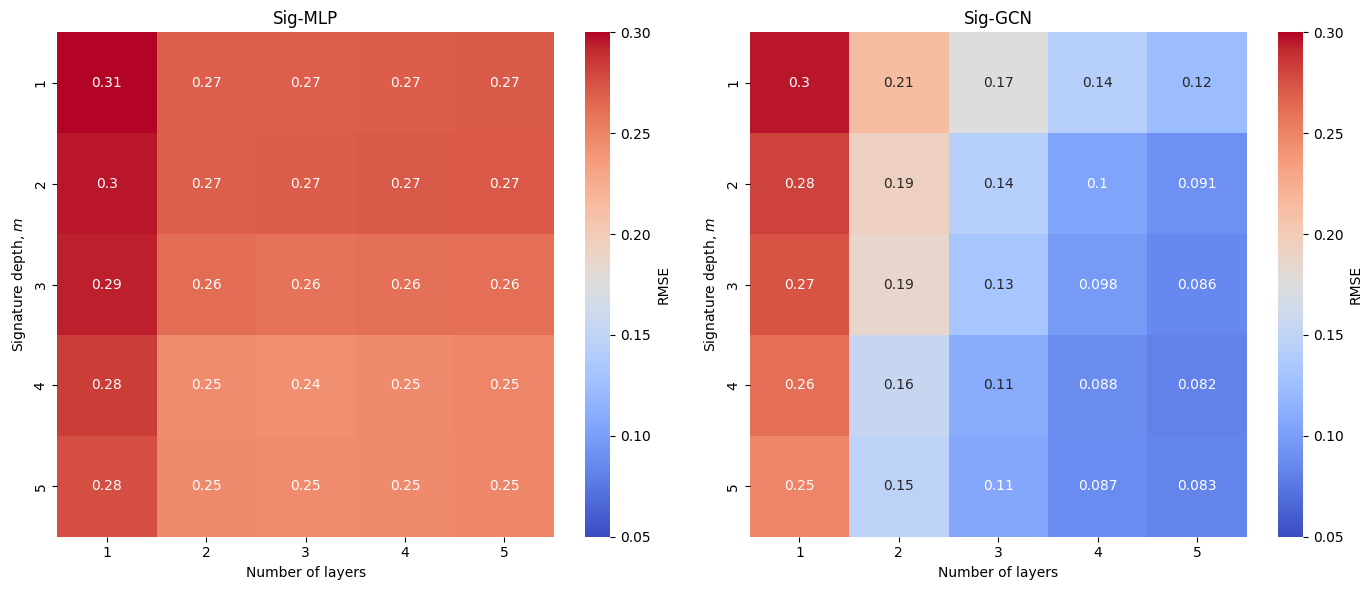

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

pivot_table_gcn = df_gcn.pivot_table(values="RMSE", index="SigDepth", columns="NumLayers")
sns.heatmap(pivot_table_gcn, annot=True, cmap="coolwarm", cbar_kws={'label': 'RMSE'}, ax=ax2, vmin=0.05, vmax=0.3)
ax2.set_xlabel('Number of layers')
ax2.set_ylabel('Signature depth, $m$')
ax2.set_title('Sig-GCN')

pivot_table_mlp = df_mlp.pivot_table(values="RMSE", index="SigDepth", columns="NumLayers")
sns.heatmap(pivot_table_mlp, annot=True, cmap="coolwarm", cbar_kws={'label': 'RMSE'}, ax=ax1, vmin=0.05, vmax=0.3)
ax1.set_xlabel('Number of layers')
ax1.set_ylabel('Signature depth, $m$')
ax1.set_title('Sig-MLP')


plt.tight_layout()

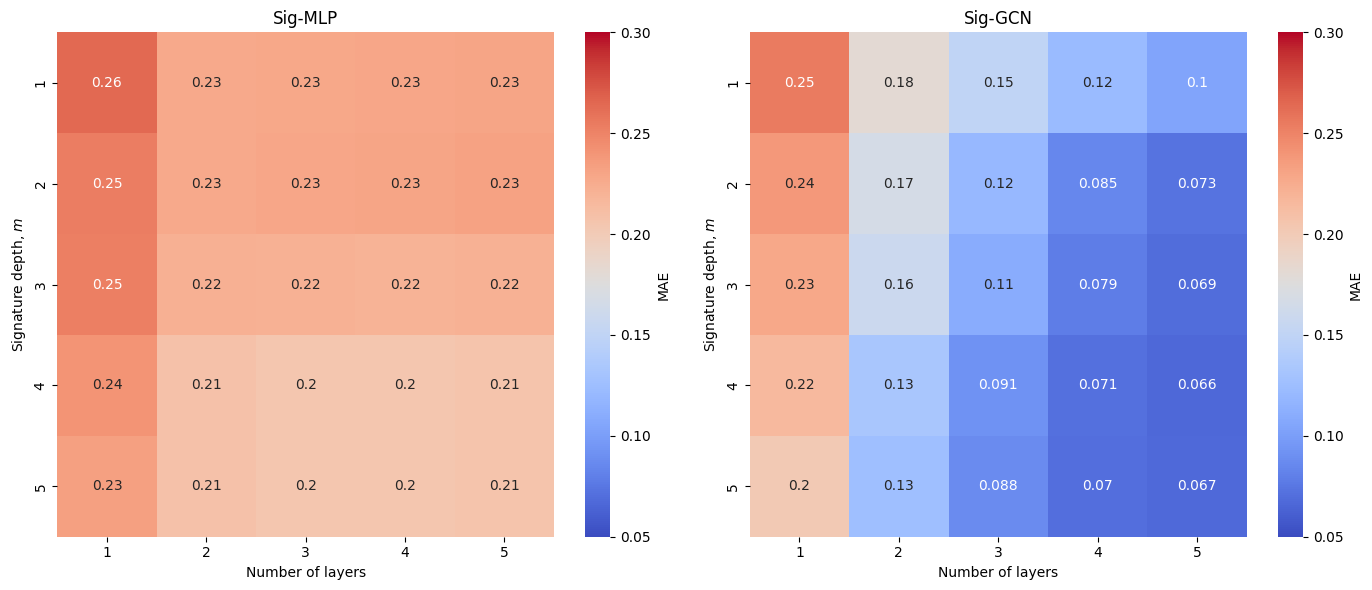

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

pivot_table_gcn = df_gcn.pivot_table(values="MAE", index="SigDepth", columns="NumLayers")
sns.heatmap(pivot_table_gcn, annot=True, cmap="coolwarm", cbar_kws={'label': 'MAE'}, ax=ax2, vmin=0.05, vmax=0.3)
ax2.set_xlabel('Number of layers')
ax2.set_ylabel('Signature depth, $m$')
ax2.set_title('Sig-GCN')

pivot_table_mlp = df_mlp.pivot_table(values="MAE", index="SigDepth", columns="NumLayers")
sns.heatmap(pivot_table_mlp, annot=True, cmap="coolwarm", cbar_kws={'label': 'MAE'}, ax=ax1, vmin=0.05, vmax=0.3)
ax1.set_xlabel('Number of layers')
ax1.set_ylabel('Signature depth, $m$')
ax1.set_title('Sig-MLP')


plt.tight_layout()

In [5]:
df_gcn['Class'] = 'GCN'
df_mlp['Class'] = 'MLP'
df = pd.concat([df_gcn, df_mlp])

In [6]:
# Group by SigDepth and NumLayers, then calculate the mean RMSE
mean_rmse = df.groupby(['Class','NumLayers', 'SigDepth'])['RMSE'].mean()
mean_mae = df.groupby(['Class','NumLayers', 'SigDepth'])['MAE'].mean()

min_rmse = mean_rmse['GCN'].min()
best_rmse = mean_rmse['GCN'].idxmin()
std_rmse = df[(df['Class'] == 'GCN') &
              (df['NumLayers'] == best_rmse[0]) & 
              (df['SigDepth'] == best_rmse[1])]['RMSE'].std()

min_rmse_mlp = mean_rmse['MLP'].min()
best_rmse_mlp = mean_rmse['MLP'].idxmin()
std_rmse_mlp = df[(df['Class'] == 'MLP') &
            (df['NumLayers'] == best_rmse_mlp[0]) & 
              (df['SigDepth'] == best_rmse_mlp[1])]['RMSE'].std()

min_mae = mean_mae['GCN'].min()
best_mae = mean_mae['GCN'].idxmin()
std_mae = df[   (df['Class'] == 'GCN') &
                (df['NumLayers'] == best_mae[0]) & 
                (df['SigDepth'] == best_mae[1])]['MAE'].std()

min_mae_mlp = mean_mae['MLP'].min()
best_mae_mlp = mean_mae['MLP'].idxmin()
std_mae_mlp = df[(df['Class'] == 'GCN') &
                (df['NumLayers'] == best_mae_mlp[0]) & 
                (df['SigDepth'] == best_mae_mlp[1])]['MAE'].std()

print(f"Best GCN: RMSE {min_rmse:.4f} ± {std_rmse:.4f}, MAE {min_mae:.4f} ± {std_mae:.4f}")
print(f"Best MLP: RMSE {min_rmse_mlp:.4f} ± {std_rmse_mlp:.4f}, MAE {min_mae_mlp:.4f} ± {std_mae_mlp:.4f}")

Best GCN: RMSE 0.0818 ± 0.0135, MAE 0.0657 ± 0.0110
Best MLP: RMSE 0.2443 ± 0.0212, MAE 0.2046 ± 0.0229


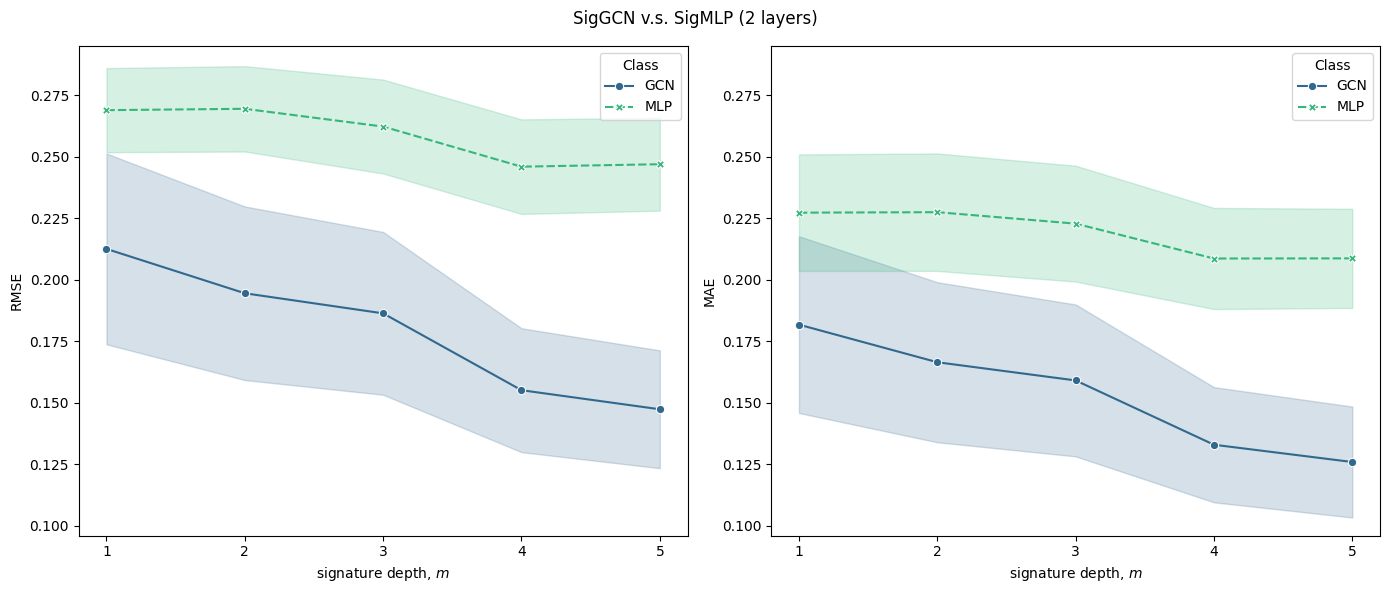

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

n_layers = 2

sns.lineplot(data=df.loc[df.NumLayers == n_layers], x='SigDepth', y='RMSE', hue='Class', style='Class', markers=True, err_style='band', errorbar='sd', palette='viridis', ax=axes[0])
axes[0].set_xlabel('signature depth, $m$')
axes[0].set_ylabel('RMSE')
axes[0].set_xticks(range(1, 6))

sns.lineplot(data=df.loc[df.NumLayers == n_layers], x='SigDepth', y='MAE', hue='Class', style='Class', markers=True, err_style='band', errorbar='sd', palette='viridis', ax=axes[1])
axes[1].set_xlabel('signature depth, $m$')
axes[1].set_ylabel('MAE')
axes[1].set_xticks(range(1, 6))

# Set the same y-axis limits for both subplots
y_min = min(axes[0].get_ylim()[0], axes[1].get_ylim()[0])
y_max = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
axes[0].set_ylim(y_min, y_max)
axes[1].set_ylim(y_min, y_max)

plt.suptitle(f'SigGCN v.s. SigMLP ({n_layers} layers)')
plt.tight_layout()
plt.show()

## Graph Recurrent Convolutional Neural Networks

100%|██████████| 20/20 [00:38<00:00,  1.94s/it]


Model: GConvGRURegression
Number of parameters: 37889


100%|██████████| 400/400 [11:27:37<00:00, 103.14s/it]  


MSE: 0.0741 ± 0.0143, MAE: 0.2307 ± 0.0285, RMSE: 0.2709 ± 0.0259


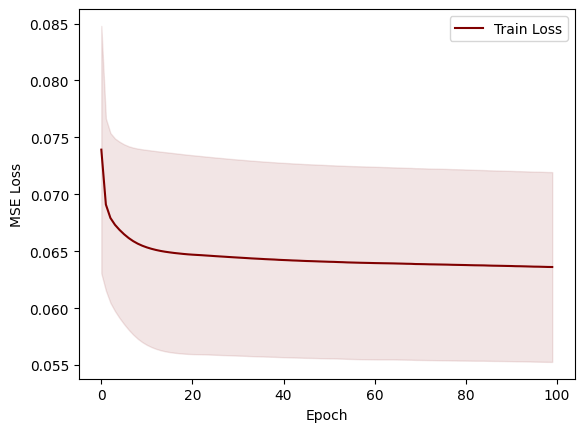

In [24]:
import torch
import torch.nn as nn
import signatory
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as T


import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GConvGRURegression,GConvLSTMRegression
from pygsig.graph import StaticGraphTemporalSignal, split_nodes
from pygsig.signature import SignatureFeatures

import importlib
importlib.reload(pygsig.models)
importlib.reload(pygsig.signature)
importlib.reload(pygsig.graph)

num_splits = 5
num_runs = len(seq_dataset)
num_trials = 4
num_epochs = 100
num_nodes = seq_dataset[0].num_nodes
dim = seq_dataset[0].num_node_features
sample_rate = 100 # only take every 'sample_rate' snapshots
num_snapshots = seq_dataset[0].snapshot_count//sample_rate

learning_rate = 1e-3
lasso = 0
num_hidden = 64

print_during_training = False


mse_models = []
mae_models = []
rmse_models = []

dataset = []
for seq in tqdm(seq_dataset):
    signature_transform = SignatureFeatures(sig_depth=4, normalize=True, log_signature=False,lead_lag=True)
    dataset.append(signature_transform(seq))

for model_class in [GConvGRURegression]:  # Iterate over the model classes
    print(f'Model: {model_class.__name__}')
    print(f"Number of parameters: {sum(p.numel() for p in model_class(num_channels=[dim, num_hidden, 1], K=3).parameters() if p.requires_grad)}")
    
    criterion = nn.MSELoss()
    
    train_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs, num_snapshots])
    eval_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs, num_snapshots])
    mse = np.zeros([num_splits, num_runs, num_trials])
    mae = np.zeros([num_splits, num_runs, num_trials])
    rmse = np.zeros([num_splits, num_runs, num_trials])

    with tqdm(total=num_splits*num_runs*num_trials, disable=print_during_training) as pbar:
        splits = split_nodes(num_nodes, num_splits, test_ratio=1.0, seed=29)
        
        for split in range(num_splits):
            train_indices, eval_indices, test_indices = splits[split]
            train_mask = torch.zeros(num_nodes, dtype=torch.bool)
            eval_mask = torch.zeros(num_nodes, dtype=torch.bool)
            test_mask = torch.zeros(num_nodes, dtype=torch.bool)
            train_mask[train_indices] = True
            eval_mask[eval_indices] = True
            test_mask[test_indices] = True
            
            for run, full_seq in enumerate(seq_dataset):
                seq = StaticGraphTemporalSignal(
                    edge_index=full_seq.edge_index, 
                    edge_weight=full_seq.edge_weight, 
                    features=full_seq.features[::sample_rate], 
                    targets=full_seq.targets[::sample_rate]
                )
                
                for trial in range(num_trials):
                    # Create a new instance of the model for each trial
                    model = model_class(num_channels=[dim, num_hidden, 1], K=3)
                    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lasso)
                    
                    for epoch in range(num_epochs):
                        for t, snapshot in enumerate(seq):
                            # Train
                            model.train()
                            optimizer.zero_grad()
                            out = model(snapshot.x, snapshot.edge_index)
                            train_loss = criterion(out[train_mask], snapshot.y[train_mask])
                            train_loss.backward()
                            optimizer.step()

                            # Evaluate
                            model.eval()
                            with torch.no_grad():
                                eval_loss = criterion(out[eval_mask], snapshot.y[eval_mask])
                                train_losses[split, run, trial, epoch, t] = train_loss.item()
                                eval_losses[split, run, trial, epoch, t] = eval_loss.item()

                        if print_during_training:
                            print(f'Split {split}, Run {run}, Trial {trial}, Epoch {epoch}, Train MSE Loss: {train_loss.item():.4f}')
                    
                    pbar.update(1)

                    # Compute the errors on the testing loss after the last epoch
                    with torch.no_grad():
                        out = model(snapshot.x, snapshot.edge_index)
                        mse[split, run, trial] = mean_squared_error(snapshot.y[test_mask], out[test_mask])
                        mae[split, run, trial] = mean_absolute_error(snapshot.y[test_mask], out[test_mask])
                        rmse[split, run, trial] = np.sqrt(mean_squared_error(snapshot.y[test_mask], out[test_mask]))

    print(f'MSE: {np.mean(mse):.4f} ± {np.std(mse):.4f}, MAE: {np.mean(mae):.4f} ± {np.std(mae):.4f}, RMSE: {np.mean(rmse):.4f} ± {np.std(rmse):.4f}')  
    mse_models.append(mse)
    mae_models.append(mae)
    rmse_models.append(rmse)

    # Plotting
    avg_train_losses = np.mean(train_losses, axis=(0, 1, 2, -1))
    avg_eval_losses = np.mean(eval_losses, axis=(0, 1, 2, -1))
    std_train_losses = np.std(train_losses, axis=(0, 1, 2, -1))
    std_eval_losses = np.std(eval_losses, axis=(0, 1, 2, -1))
    
    plt.figure()
    plt.plot(avg_train_losses, label='Train Loss', color='maroon')
    plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.1, color='maroon')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()